In [0]:
#!unzip leapGestRecog.zip

In [0]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models

In [ ]:
transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

alldataset = torchvision.datasets.ImageFolder(root='./leapGestRecog/00', transform=transform)

for i in range(1, 10):
    folder = torchvision.datasets.ImageFolder(root='./leapGestRecog/0{}'.format(i), transform=transform)
    alldataset = torch.utils.data.ConcatDataset([alldataset, folder])
    
num_train = len(alldataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, test_idx = indices[split:], indices[:split]
train_idx, valid_idx = train_idx[split:], train_idx[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(
    alldataset, batch_size=4, sampler=train_sampler,
    num_workers=2
)
validloader = torch.utils.data.DataLoader(
    alldataset, batch_size=4, sampler=valid_sampler,
    num_workers=2
)
testloader = torch.utils.data.DataLoader(
    alldataset, batch_size=4, sampler=test_sampler,
    num_workers=2
)

classes = ('01_palm', '02_l', '03_fist', '04_fist_moved',
           '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down')

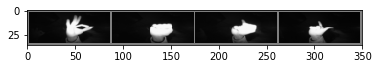

07_ok 03_fist 06_index  02_l


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:

model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
epochs = 5
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(validloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/5.. Train loss: 4.580.. Test loss: 3.253.. Test accuracy: 0.197
Epoch 1/5.. Train loss: 2.263.. Test loss: 2.514.. Test accuracy: 0.214
Epoch 1/5.. Train loss: 2.025.. Test loss: 2.477.. Test accuracy: 0.300
Epoch 1/5.. Train loss: 2.037.. Test loss: 2.218.. Test accuracy: 0.303
Epoch 1/5.. Train loss: 1.564.. Test loss: 2.724.. Test accuracy: 0.221
Epoch 1/5.. Train loss: 1.860.. Test loss: 1.975.. Test accuracy: 0.444
Epoch 1/5.. Train loss: 1.576.. Test loss: 1.616.. Test accuracy: 0.472
Epoch 1/5.. Train loss: 1.211.. Test loss: 1.496.. Test accuracy: 0.565
Epoch 1/5.. Train loss: 1.363.. Test loss: 1.017.. Test accuracy: 0.676
Epoch 1/5.. Train loss: 1.281.. Test loss: 1.068.. Test accuracy: 0.672
Epoch 1/5.. Train loss: 1.511.. Test loss: 0.637.. Test accuracy: 0.834
Epoch 1/5.. Train loss: 1.398.. Test loss: 0.750.. Test accuracy: 0.762
Epoch 1/5.. Train loss: 0.722.. Test loss: 0.914.. Test accuracy: 0.719
Epoch 1/5.. Train loss: 1.541.. Test loss: 0.664.. Test accuracy

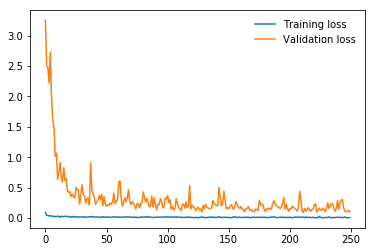

In [29]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()